# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sign-adjusted topics (BCC) most strongly correlated with Consumption at t+3 (out of 200 topics estimated on articles published before 2010 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sign-adjusted topics most strongly correlated with Consumption at t+3, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")
        
        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11856
EM converged at iteration 59, llf=-11589, convergence criterion=9.7869e-07 < tolerance=1e-06
EM start iterations, llf=-11869
EM converged at iteration 59, llf=-11601, convergence criterion=9.7799e-07 < tolerance=1e-06
EM start iterations, llf=-11923
EM converged at iteration 59, llf=-11653, convergence criterion=9.858e-07 < tolerance=1e-06
EM start iterations, llf=-11930
EM converged at iteration 59, llf=-11660, convergence criterion=9.8585e-07 < tolerance=1e-06
EM start iterations, llf=-11992
EM converged at iteration 60, llf=-11718, convergence criterion=9.9776e-07 < tolerance=1e-06
EM start iterations, llf=-12000
EM converged at iteration 60, llf=-11725, convergence criterion=9.9477e-07 < tolerance=1e-06
EM start iterations, llf=-12058
EM converged at iteration 60, llf=-11783, convergence criterion=9.9032e-07 < tolerance=1e-06
EM start iterations, llf=-12058
EM converged at iteration 60, llf=-11783, convergence criterion=9.9032e-07 < tolerance=1e-06
E

EM start iterations, llf=-13574
EM converged at iteration 50, llf=-13354, convergence criterion=9.6505e-07 < tolerance=1e-06
EM start iterations, llf=-13633
EM converged at iteration 48, llf=-13424, convergence criterion=9.6987e-07 < tolerance=1e-06
EM start iterations, llf=-13639
EM converged at iteration 48, llf=-13427, convergence criterion=9.7003e-07 < tolerance=1e-06
EM start iterations, llf=-13692
EM converged at iteration 48, llf=-13475, convergence criterion=9.7478e-07 < tolerance=1e-06
EM start iterations, llf=-13692
EM converged at iteration 48, llf=-13475, convergence criterion=9.7478e-07 < tolerance=1e-06
EM start iterations, llf=-13703
EM converged at iteration 48, llf=-13488, convergence criterion=9.82e-07 < tolerance=1e-06
EM start iterations, llf=-13755
EM converged at iteration 48, llf=-13540, convergence criterion=9.7263e-07 < tolerance=1e-06
EM start iterations, llf=-13759
EM converged at iteration 48, llf=-13544, convergence criterion=9.7224e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15305
EM converged at iteration 49, llf=-15068, convergence criterion=9.9022e-07 < tolerance=1e-06
EM start iterations, llf=-15305
EM converged at iteration 49, llf=-15068, convergence criterion=9.9022e-07 < tolerance=1e-06
EM start iterations, llf=-15315
EM converged at iteration 49, llf=-15078, convergence criterion=9.8945e-07 < tolerance=1e-06
EM start iterations, llf=-15368
EM converged at iteration 49, llf=-15131, convergence criterion=9.858e-07 < tolerance=1e-06
EM start iterations, llf=-15379
EM converged at iteration 49, llf=-15142, convergence criterion=9.8295e-07 < tolerance=1e-06
EM start iterations, llf=-15428
EM converged at iteration 49, llf=-15191, convergence criterion=9.8704e-07 < tolerance=1e-06
EM start iterations, llf=-15436
EM converged at iteration 49, llf=-15198, convergence criterion=9.8505e-07 < tolerance=1e-06
EM start iterations, llf=-15484
EM converged at iteration 49, llf=-15244, convergence criterion=9.8028e-07 < tolerance=1e-06
E

EM start iterations, llf=-17018
EM converged at iteration 57, llf=-16744, convergence criterion=9.7415e-07 < tolerance=1e-06
EM start iterations, llf=-17023
EM converged at iteration 57, llf=-16749, convergence criterion=9.7415e-07 < tolerance=1e-06
EM start iterations, llf=-17077
EM converged at iteration 57, llf=-16803, convergence criterion=9.7788e-07 < tolerance=1e-06
EM start iterations, llf=-17084
EM converged at iteration 57, llf=-16809, convergence criterion=9.7808e-07 < tolerance=1e-06
EM start iterations, llf=-17141
EM converged at iteration 57, llf=-16867, convergence criterion=9.8142e-07 < tolerance=1e-06
EM start iterations, llf=-17141
EM converged at iteration 57, llf=-16867, convergence criterion=9.8142e-07 < tolerance=1e-06
EM start iterations, llf=-17150
EM converged at iteration 57, llf=-16877, convergence criterion=9.796e-07 < tolerance=1e-06
EM start iterations, llf=-17202
EM converged at iteration 57, llf=-16929, convergence criterion=9.7532e-07 < tolerance=1e-06
E

EM start iterations, llf=-18553
EM converged at iteration 58, llf=-18264, convergence criterion=9.7591e-07 < tolerance=1e-06
EM start iterations, llf=-18609
EM converged at iteration 58, llf=-18319, convergence criterion=9.7102e-07 < tolerance=1e-06
EM start iterations, llf=-18609
EM converged at iteration 58, llf=-18319, convergence criterion=9.7102e-07 < tolerance=1e-06
EM start iterations, llf=-18615
EM converged at iteration 58, llf=-18324, convergence criterion=9.7095e-07 < tolerance=1e-06
EM start iterations, llf=-18668
EM converged at iteration 58, llf=-18375, convergence criterion=9.6916e-07 < tolerance=1e-06
EM start iterations, llf=-18674
EM converged at iteration 58, llf=-18382, convergence criterion=9.6851e-07 < tolerance=1e-06
EM start iterations, llf=-18730
EM converged at iteration 58, llf=-18436, convergence criterion=9.7396e-07 < tolerance=1e-06
EM start iterations, llf=-18738
EM converged at iteration 58, llf=-18444, convergence criterion=9.7388e-07 < tolerance=1e-06


EM start iterations, llf=-12413
EM converged at iteration 59, llf=-12121, convergence criterion=9.784e-07 < tolerance=1e-06
EM start iterations, llf=-12395
EM converged at iteration 59, llf=-12101, convergence criterion=9.7342e-07 < tolerance=1e-06
EM start iterations, llf=-12442
EM converged at iteration 58, llf=-12158, convergence criterion=9.9421e-07 < tolerance=1e-06
EM start iterations, llf=-12461
EM converged at iteration 58, llf=-12183, convergence criterion=9.9118e-07 < tolerance=1e-06
EM start iterations, llf=-12529
EM converged at iteration 59, llf=-12273, convergence criterion=9.8259e-07 < tolerance=1e-06
EM start iterations, llf=-12528
EM converged at iteration 59, llf=-12270, convergence criterion=9.7527e-07 < tolerance=1e-06
EM start iterations, llf=-12549
EM converged at iteration 57, llf=-12299, convergence criterion=9.8483e-07 < tolerance=1e-06
EM start iterations, llf=-12549
EM converged at iteration 57, llf=-12299, convergence criterion=9.8483e-07 < tolerance=1e-06
E

EM start iterations, llf=-14119
EM converged at iteration 55, llf=-13888, convergence criterion=9.6288e-07 < tolerance=1e-06
EM start iterations, llf=-14157
EM converged at iteration 54, llf=-13919, convergence criterion=9.7717e-07 < tolerance=1e-06
EM start iterations, llf=-14163
EM converged at iteration 55, llf=-13931, convergence criterion=9.7179e-07 < tolerance=1e-06
EM start iterations, llf=-14214
EM converged at iteration 57, llf=-13989, convergence criterion=9.6598e-07 < tolerance=1e-06
EM start iterations, llf=-14214
EM converged at iteration 57, llf=-13989, convergence criterion=9.6598e-07 < tolerance=1e-06
EM start iterations, llf=-14224
EM converged at iteration 57, llf=-14000, convergence criterion=9.6904e-07 < tolerance=1e-06
EM start iterations, llf=-14279
EM converged at iteration 56, llf=-14053, convergence criterion=9.9579e-07 < tolerance=1e-06
EM start iterations, llf=-14286
EM converged at iteration 56, llf=-14059, convergence criterion=9.788e-07 < tolerance=1e-06
E

EM start iterations, llf=-15862
EM converged at iteration 54, llf=-15609, convergence criterion=9.8982e-07 < tolerance=1e-06
EM start iterations, llf=-15862
EM converged at iteration 54, llf=-15609, convergence criterion=9.8982e-07 < tolerance=1e-06
EM start iterations, llf=-15870
EM converged at iteration 54, llf=-15617, convergence criterion=9.7652e-07 < tolerance=1e-06
EM start iterations, llf=-15923
EM converged at iteration 54, llf=-15668, convergence criterion=9.7452e-07 < tolerance=1e-06
EM start iterations, llf=-15926
EM converged at iteration 54, llf=-15670, convergence criterion=9.7741e-07 < tolerance=1e-06
EM start iterations, llf=-15983
EM converged at iteration 54, llf=-15726, convergence criterion=9.96e-07 < tolerance=1e-06
EM start iterations, llf=-15988
EM converged at iteration 54, llf=-15730, convergence criterion=9.9416e-07 < tolerance=1e-06
EM start iterations, llf=-16033
EM converged at iteration 54, llf=-15776, convergence criterion=9.8297e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17579
EM converged at iteration 61, llf=-17308, convergence criterion=9.9172e-07 < tolerance=1e-06
EM start iterations, llf=-17585
EM converged at iteration 61, llf=-17313, convergence criterion=9.9081e-07 < tolerance=1e-06
EM start iterations, llf=-17638
EM converged at iteration 61, llf=-17365, convergence criterion=9.9854e-07 < tolerance=1e-06
EM start iterations, llf=-17646
EM converged at iteration 61, llf=-17372, convergence criterion=9.9491e-07 < tolerance=1e-06
EM start iterations, llf=-17693
EM converged at iteration 61, llf=-17418, convergence criterion=9.9242e-07 < tolerance=1e-06
EM start iterations, llf=-17693
EM converged at iteration 61, llf=-17418, convergence criterion=9.9242e-07 < tolerance=1e-06
EM start iterations, llf=-17712
EM converged at iteration 61, llf=-17438, convergence criterion=9.9248e-07 < tolerance=1e-06
EM start iterations, llf=-17765
EM converged at iteration 61, llf=-17490, convergence criterion=9.8233e-07 < tolerance=1e-06


EM start iterations, llf=-19104
EM converged at iteration 61, llf=-18798, convergence criterion=9.7787e-07 < tolerance=1e-06
EM start iterations, llf=-19151
EM converged at iteration 61, llf=-18846, convergence criterion=9.7438e-07 < tolerance=1e-06
EM start iterations, llf=-19151
EM converged at iteration 61, llf=-18846, convergence criterion=9.7438e-07 < tolerance=1e-06
EM start iterations, llf=-19159
EM converged at iteration 61, llf=-18855, convergence criterion=9.7547e-07 < tolerance=1e-06
EM start iterations, llf=-19211
EM converged at iteration 61, llf=-18908, convergence criterion=9.7522e-07 < tolerance=1e-06
EM start iterations, llf=-19219
EM converged at iteration 61, llf=-18915, convergence criterion=9.7418e-07 < tolerance=1e-06
EM start iterations, llf=-19270
EM converged at iteration 60, llf=-18966, convergence criterion=9.9156e-07 < tolerance=1e-06
EM start iterations, llf=-19279
EM converged at iteration 60, llf=-18974, convergence criterion=9.9008e-07 < tolerance=1e-06


EM start iterations, llf=-12899
EM converged at iteration 71, llf=-12658, convergence criterion=9.8933e-07 < tolerance=1e-06
EM start iterations, llf=-12904
EM converged at iteration 71, llf=-12664, convergence criterion=9.8806e-07 < tolerance=1e-06
EM start iterations, llf=-12955
EM converged at iteration 69, llf=-12712, convergence criterion=9.9705e-07 < tolerance=1e-06
EM start iterations, llf=-12962
EM converged at iteration 69, llf=-12719, convergence criterion=9.9727e-07 < tolerance=1e-06
EM start iterations, llf=-13006
EM converged at iteration 67, llf=-12758, convergence criterion=9.7955e-07 < tolerance=1e-06
EM start iterations, llf=-13017
EM converged at iteration 67, llf=-12768, convergence criterion=9.7576e-07 < tolerance=1e-06
EM start iterations, llf=-13077
EM converged at iteration 68, llf=-12836, convergence criterion=9.9852e-07 < tolerance=1e-06
EM start iterations, llf=-13077
EM converged at iteration 68, llf=-12836, convergence criterion=9.9852e-07 < tolerance=1e-06


EM start iterations, llf=-14635
EM converged at iteration 67, llf=-14404, convergence criterion=9.996e-07 < tolerance=1e-06
EM start iterations, llf=-14692
EM converged at iteration 66, llf=-14464, convergence criterion=9.8161e-07 < tolerance=1e-06
EM start iterations, llf=-14700
EM converged at iteration 65, llf=-14470, convergence criterion=9.9571e-07 < tolerance=1e-06
EM start iterations, llf=-14755
EM converged at iteration 66, llf=-14527, convergence criterion=9.9272e-07 < tolerance=1e-06
EM start iterations, llf=-14755
EM converged at iteration 66, llf=-14527, convergence criterion=9.9272e-07 < tolerance=1e-06
EM start iterations, llf=-14763
EM converged at iteration 66, llf=-14533, convergence criterion=9.8551e-07 < tolerance=1e-06
EM start iterations, llf=-14818
EM converged at iteration 58, llf=-14586, convergence criterion=9.9592e-07 < tolerance=1e-06
EM start iterations, llf=-14826
EM converged at iteration 58, llf=-14593, convergence criterion=9.7886e-07 < tolerance=1e-06
E

EM start iterations, llf=-16401
EM converged at iteration 61, llf=-16143, convergence criterion=9.9726e-07 < tolerance=1e-06
EM start iterations, llf=-16401
EM converged at iteration 61, llf=-16143, convergence criterion=9.9726e-07 < tolerance=1e-06
EM start iterations, llf=-16410
EM converged at iteration 61, llf=-16152, convergence criterion=9.8989e-07 < tolerance=1e-06
EM start iterations, llf=-16462
EM converged at iteration 59, llf=-16202, convergence criterion=9.7266e-07 < tolerance=1e-06
EM start iterations, llf=-16471
EM converged at iteration 58, llf=-16211, convergence criterion=9.998e-07 < tolerance=1e-06
EM start iterations, llf=-16521
EM converged at iteration 58, llf=-16261, convergence criterion=9.8106e-07 < tolerance=1e-06
EM start iterations, llf=-16528
EM converged at iteration 58, llf=-16268, convergence criterion=9.7774e-07 < tolerance=1e-06
EM start iterations, llf=-16582
EM converged at iteration 55, llf=-16320, convergence criterion=9.9825e-07 < tolerance=1e-06
E

EM start iterations, llf=-18117
EM converged at iteration 61, llf=-17837, convergence criterion=9.9936e-07 < tolerance=1e-06
EM start iterations, llf=-18124
EM converged at iteration 62, llf=-17845, convergence criterion=9.6915e-07 < tolerance=1e-06
EM start iterations, llf=-18176
EM converged at iteration 62, llf=-17895, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-18183
EM converged at iteration 62, llf=-17903, convergence criterion=9.8392e-07 < tolerance=1e-06
EM start iterations, llf=-18239
EM converged at iteration 65, llf=-17958, convergence criterion=9.8341e-07 < tolerance=1e-06
EM start iterations, llf=-18239
EM converged at iteration 65, llf=-17958, convergence criterion=9.8341e-07 < tolerance=1e-06
EM start iterations, llf=-18243
EM converged at iteration 65, llf=-17960, convergence criterion=9.8064e-07 < tolerance=1e-06
EM start iterations, llf=-18296
EM converged at iteration 68, llf=-18012, convergence criterion=9.794e-07 < tolerance=1e-06
E

EM start iterations, llf=-19355
EM converged at iteration 72, llf=-19043, convergence criterion=9.8219e-07 < tolerance=1e-06
EM start iterations, llf=-19410
EM converged at iteration 72, llf=-19099, convergence criterion=9.7768e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:29:10.695333.
EM start iterations, llf=-11380
EM converged at iteration 57, llf=-11214, convergence criterion=9.9562e-07 < tolerance=1e-06
EM start iterations, llf=-11393
EM converged at iteration 58, llf=-11227, convergence criterion=9.7239e-07 < tolerance=1e-06
EM start iterations, llf=-11446
EM converged at iteration 57, llf=-11280, convergence criterion=9.9415e-07 < tolerance=1e-06
EM start iterations, llf=-11454
EM converged at iteration 58, llf=-11288, convergence criterion=9.7042e-07 < tolerance=1e-06
EM start iterations, llf=-11510
EM converged at iteration 57, llf=-11344, convergence criterion=9.9552e-07 < tolerance=1e-06
EM start iterations, llf=-11520
EM converged at

EM start iterations, llf=-12861
EM converged at iteration 51, llf=-12689, convergence criterion=9.982e-07 < tolerance=1e-06
EM start iterations, llf=-12874
EM converged at iteration 51, llf=-12701, convergence criterion=9.9948e-07 < tolerance=1e-06
EM start iterations, llf=-12908
EM converged at iteration 51, llf=-12734, convergence criterion=9.7337e-07 < tolerance=1e-06
EM start iterations, llf=-12915
EM converged at iteration 51, llf=-12738, convergence criterion=9.7382e-07 < tolerance=1e-06
EM start iterations, llf=-12971
EM converged at iteration 49, llf=-12788, convergence criterion=9.9496e-07 < tolerance=1e-06
EM start iterations, llf=-12976
EM converged at iteration 49, llf=-12795, convergence criterion=9.9259e-07 < tolerance=1e-06
EM start iterations, llf=-13017
EM converged at iteration 49, llf=-12837, convergence criterion=9.811e-07 < tolerance=1e-06
EM start iterations, llf=-13017
EM converged at iteration 49, llf=-12837, convergence criterion=9.811e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-14471
EM converged at iteration 46, llf=-14280, convergence criterion=9.9726e-07 < tolerance=1e-06
EM start iterations, llf=-14522
EM converged at iteration 48, llf=-14331, convergence criterion=9.8441e-07 < tolerance=1e-06
EM start iterations, llf=-14530
EM converged at iteration 48, llf=-14339, convergence criterion=9.8315e-07 < tolerance=1e-06
EM start iterations, llf=-14579
EM converged at iteration 48, llf=-14388, convergence criterion=9.7801e-07 < tolerance=1e-06
EM start iterations, llf=-14579
EM converged at iteration 48, llf=-14388, convergence criterion=9.7801e-07 < tolerance=1e-06
EM start iterations, llf=-14587
EM converged at iteration 48, llf=-14397, convergence criterion=9.7866e-07 < tolerance=1e-06
EM start iterations, llf=-14638
EM converged at iteration 48, llf=-14447, convergence criterion=9.7153e-07 < tolerance=1e-06
EM start iterations, llf=-14645
EM converged at iteration 48, llf=-14454, convergence criterion=9.6934e-07 < tolerance=1e-06


EM start iterations, llf=-16165
EM converged at iteration 57, llf=-15962, convergence criterion=9.8382e-07 < tolerance=1e-06
EM start iterations, llf=-16165
EM converged at iteration 57, llf=-15962, convergence criterion=9.8382e-07 < tolerance=1e-06
EM start iterations, llf=-16179
EM converged at iteration 57, llf=-15975, convergence criterion=9.8206e-07 < tolerance=1e-06
EM start iterations, llf=-16237
EM converged at iteration 57, llf=-16034, convergence criterion=9.9039e-07 < tolerance=1e-06
EM start iterations, llf=-16239
EM converged at iteration 57, llf=-16037, convergence criterion=9.942e-07 < tolerance=1e-06
EM start iterations, llf=-16292
EM converged at iteration 58, llf=-16090, convergence criterion=9.826e-07 < tolerance=1e-06
EM start iterations, llf=-16299
EM converged at iteration 58, llf=-16097, convergence criterion=9.8385e-07 < tolerance=1e-06
EM start iterations, llf=-16353
EM converged at iteration 58, llf=-16151, convergence criterion=9.8628e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17626
EM converged at iteration 58, llf=-17415, convergence criterion=9.8443e-07 < tolerance=1e-06
EM start iterations, llf=-17640
EM converged at iteration 58, llf=-17428, convergence criterion=9.8273e-07 < tolerance=1e-06
EM start iterations, llf=-17700
EM converged at iteration 58, llf=-17487, convergence criterion=9.8805e-07 < tolerance=1e-06
EM start iterations, llf=-17705
EM converged at iteration 58, llf=-17493, convergence criterion=9.874e-07 < tolerance=1e-06
EM start iterations, llf=-17758
EM converged at iteration 58, llf=-17545, convergence criterion=9.8084e-07 < tolerance=1e-06
EM start iterations, llf=-17758
EM converged at iteration 58, llf=-17545, convergence criterion=9.8084e-07 < tolerance=1e-06
EM start iterations, llf=-17763
EM converged at iteration 58, llf=-17551, convergence criterion=9.8103e-07 < tolerance=1e-06
EM start iterations, llf=-17812
EM converged at iteration 58, llf=-17599, convergence criterion=9.7776e-07 < tolerance=1e-06
E

EM start iterations, llf=-11832
EM converged at iteration 68, llf=-11661, convergence criterion=9.7371e-07 < tolerance=1e-06
EM start iterations, llf=-11835
EM converged at iteration 66, llf=-11663, convergence criterion=9.9929e-07 < tolerance=1e-06
EM start iterations, llf=-11903
EM converged at iteration 63, llf=-11731, convergence criterion=9.9897e-07 < tolerance=1e-06
EM start iterations, llf=-11903
EM converged at iteration 63, llf=-11731, convergence criterion=9.9897e-07 < tolerance=1e-06
EM start iterations, llf=-11914
EM converged at iteration 64, llf=-11744, convergence criterion=9.8482e-07 < tolerance=1e-06
EM start iterations, llf=-11974
EM converged at iteration 62, llf=-11807, convergence criterion=9.9744e-07 < tolerance=1e-06
EM start iterations, llf=-11960
EM converged at iteration 63, llf=-11793, convergence criterion=9.7472e-07 < tolerance=1e-06
EM start iterations, llf=-11983
EM converged at iteration 61, llf=-11808, convergence criterion=9.9924e-07 < tolerance=1e-06


EM start iterations, llf=-13362
EM converged at iteration 57, llf=-13175, convergence criterion=9.9162e-07 < tolerance=1e-06
EM start iterations, llf=-13371
EM converged at iteration 57, llf=-13186, convergence criterion=9.7885e-07 < tolerance=1e-06
EM start iterations, llf=-13419
EM converged at iteration 57, llf=-13234, convergence criterion=9.9763e-07 < tolerance=1e-06
EM start iterations, llf=-13428
EM converged at iteration 57, llf=-13242, convergence criterion=9.9497e-07 < tolerance=1e-06
EM start iterations, llf=-13473
EM converged at iteration 58, llf=-13286, convergence criterion=9.7282e-07 < tolerance=1e-06
EM start iterations, llf=-13465
EM converged at iteration 58, llf=-13283, convergence criterion=9.7079e-07 < tolerance=1e-06
EM start iterations, llf=-13511
EM converged at iteration 58, llf=-13327, convergence criterion=9.7747e-07 < tolerance=1e-06
EM start iterations, llf=-13511
EM converged at iteration 58, llf=-13327, convergence criterion=9.7747e-07 < tolerance=1e-06


EM start iterations, llf=-15002
EM converged at iteration 54, llf=-14809, convergence criterion=9.6835e-07 < tolerance=1e-06
EM start iterations, llf=-15055
EM converged at iteration 53, llf=-14862, convergence criterion=9.6668e-07 < tolerance=1e-06
EM start iterations, llf=-15061
EM converged at iteration 53, llf=-14868, convergence criterion=9.8343e-07 < tolerance=1e-06
EM start iterations, llf=-15106
EM converged at iteration 53, llf=-14915, convergence criterion=9.7751e-07 < tolerance=1e-06
EM start iterations, llf=-15106
EM converged at iteration 53, llf=-14915, convergence criterion=9.7751e-07 < tolerance=1e-06
EM start iterations, llf=-15119
EM converged at iteration 53, llf=-14926, convergence criterion=9.7425e-07 < tolerance=1e-06
EM start iterations, llf=-15174
EM converged at iteration 53, llf=-14979, convergence criterion=9.7809e-07 < tolerance=1e-06
EM start iterations, llf=-15173
EM converged at iteration 53, llf=-14980, convergence criterion=9.7257e-07 < tolerance=1e-06


EM start iterations, llf=-16696
EM converged at iteration 62, llf=-16489, convergence criterion=9.9507e-07 < tolerance=1e-06
EM start iterations, llf=-16696
EM converged at iteration 62, llf=-16489, convergence criterion=9.9507e-07 < tolerance=1e-06
EM start iterations, llf=-16705
EM converged at iteration 62, llf=-16496, convergence criterion=9.964e-07 < tolerance=1e-06
EM start iterations, llf=-16757
EM converged at iteration 62, llf=-16548, convergence criterion=9.9328e-07 < tolerance=1e-06
EM start iterations, llf=-16761
EM converged at iteration 62, llf=-16552, convergence criterion=9.933e-07 < tolerance=1e-06
EM start iterations, llf=-16813
EM converged at iteration 62, llf=-16605, convergence criterion=9.983e-07 < tolerance=1e-06
EM start iterations, llf=-16823
EM converged at iteration 62, llf=-16614, convergence criterion=9.9687e-07 < tolerance=1e-06
EM start iterations, llf=-16866
EM converged at iteration 62, llf=-16658, convergence criterion=9.991e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-18163
EM converged at iteration 62, llf=-17947, convergence criterion=9.7949e-07 < tolerance=1e-06
EM start iterations, llf=-18170
EM converged at iteration 62, llf=-17953, convergence criterion=9.7786e-07 < tolerance=1e-06
EM start iterations, llf=-18220
EM converged at iteration 62, llf=-18003, convergence criterion=9.8111e-07 < tolerance=1e-06
EM start iterations, llf=-18227
EM converged at iteration 62, llf=-18010, convergence criterion=9.7705e-07 < tolerance=1e-06
EM start iterations, llf=-18270
EM converged at iteration 62, llf=-18053, convergence criterion=9.7633e-07 < tolerance=1e-06
EM start iterations, llf=-18270
EM converged at iteration 62, llf=-18053, convergence criterion=9.7633e-07 < tolerance=1e-06
EM start iterations, llf=-18275
EM converged at iteration 62, llf=-18057, convergence criterion=9.7812e-07 < tolerance=1e-06
EM start iterations, llf=-18326
EM converged at iteration 62, llf=-18108, convergence criterion=9.7321e-07 < tolerance=1e-06


EM start iterations, llf=-12252
EM converged at iteration 82, llf=-12076, convergence criterion=9.9166e-07 < tolerance=1e-06
EM start iterations, llf=-12268
EM converged at iteration 80, llf=-12087, convergence criterion=9.9804e-07 < tolerance=1e-06
EM start iterations, llf=-12316
EM converged at iteration 80, llf=-12135, convergence criterion=9.9848e-07 < tolerance=1e-06
EM start iterations, llf=-12316
EM converged at iteration 80, llf=-12135, convergence criterion=9.9848e-07 < tolerance=1e-06
EM start iterations, llf=-12317
EM converged at iteration 83, llf=-12138, convergence criterion=9.863e-07 < tolerance=1e-06
EM start iterations, llf=-12357
EM converged at iteration 83, llf=-12181, convergence criterion=9.9108e-07 < tolerance=1e-06
EM start iterations, llf=-12368
EM converged at iteration 82, llf=-12190, convergence criterion=9.8575e-07 < tolerance=1e-06
EM start iterations, llf=-12413
EM converged at iteration 81, llf=-12239, convergence criterion=9.9713e-07 < tolerance=1e-06
E

EM start iterations, llf=-13857
EM converged at iteration 81, llf=-13670, convergence criterion=9.8543e-07 < tolerance=1e-06
EM start iterations, llf=-13864
EM converged at iteration 81, llf=-13676, convergence criterion=9.8793e-07 < tolerance=1e-06
EM start iterations, llf=-13919
EM converged at iteration 77, llf=-13730, convergence criterion=9.8406e-07 < tolerance=1e-06
EM start iterations, llf=-13925
EM converged at iteration 76, llf=-13736, convergence criterion=9.9894e-07 < tolerance=1e-06
EM start iterations, llf=-13977
EM converged at iteration 75, llf=-13789, convergence criterion=9.9699e-07 < tolerance=1e-06
EM start iterations, llf=-13986
EM converged at iteration 75, llf=-13798, convergence criterion=9.8282e-07 < tolerance=1e-06
EM start iterations, llf=-14040
EM converged at iteration 74, llf=-13851, convergence criterion=9.8738e-07 < tolerance=1e-06
EM start iterations, llf=-14040
EM converged at iteration 74, llf=-13851, convergence criterion=9.8738e-07 < tolerance=1e-06


EM start iterations, llf=-15518
EM converged at iteration 71, llf=-15322, convergence criterion=9.9329e-07 < tolerance=1e-06
EM start iterations, llf=-15574
EM converged at iteration 70, llf=-15376, convergence criterion=9.9969e-07 < tolerance=1e-06
EM start iterations, llf=-15579
EM converged at iteration 71, llf=-15381, convergence criterion=9.7732e-07 < tolerance=1e-06
EM start iterations, llf=-15635
EM converged at iteration 69, llf=-15437, convergence criterion=9.9875e-07 < tolerance=1e-06
EM start iterations, llf=-15635
EM converged at iteration 69, llf=-15437, convergence criterion=9.9875e-07 < tolerance=1e-06
EM start iterations, llf=-15645
EM converged at iteration 69, llf=-15446, convergence criterion=9.9335e-07 < tolerance=1e-06
EM start iterations, llf=-15695
EM converged at iteration 66, llf=-15496, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-15703
EM converged at iteration 66, llf=-15505, convergence criterion=9.9167e-07 < tolerance=1e-06


EM start iterations, llf=-17230
EM converged at iteration 72, llf=-17020, convergence criterion=9.7997e-07 < tolerance=1e-06
EM start iterations, llf=-17230
EM converged at iteration 72, llf=-17020, convergence criterion=9.7997e-07 < tolerance=1e-06
EM start iterations, llf=-17237
EM converged at iteration 72, llf=-17027, convergence criterion=9.8284e-07 < tolerance=1e-06
EM start iterations, llf=-17285
EM converged at iteration 72, llf=-17074, convergence criterion=9.8922e-07 < tolerance=1e-06
EM start iterations, llf=-17292
EM converged at iteration 72, llf=-17080, convergence criterion=9.8607e-07 < tolerance=1e-06
EM start iterations, llf=-17342
EM converged at iteration 73, llf=-17130, convergence criterion=9.7767e-07 < tolerance=1e-06
EM start iterations, llf=-17350
EM converged at iteration 73, llf=-17137, convergence criterion=9.8018e-07 < tolerance=1e-06
EM start iterations, llf=-17404
EM converged at iteration 78, llf=-17191, convergence criterion=9.8723e-07 < tolerance=1e-06


EM start iterations, llf=-18389
EM converged at iteration 80, llf=-18173, convergence criterion=9.8929e-07 < tolerance=1e-06
EM start iterations, llf=-18400
EM converged at iteration 80, llf=-18184, convergence criterion=9.8758e-07 < tolerance=1e-06
EM start iterations, llf=-18455
EM converged at iteration 80, llf=-18238, convergence criterion=9.9819e-07 < tolerance=1e-06
EM start iterations, llf=-18459
EM converged at iteration 80, llf=-18243, convergence criterion=9.9859e-07 < tolerance=1e-06
EM start iterations, llf=-18512
EM converged at iteration 80, llf=-18296, convergence criterion=9.8994e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 3:27:27.562967.
Overall time taken for running all models: 15:39:56.981041.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


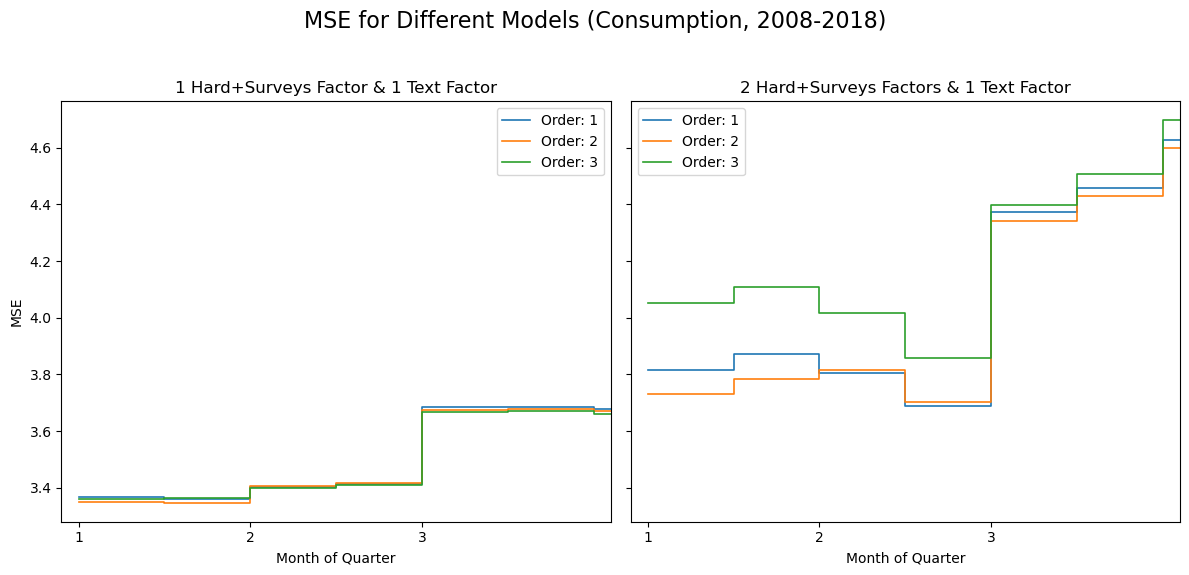

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


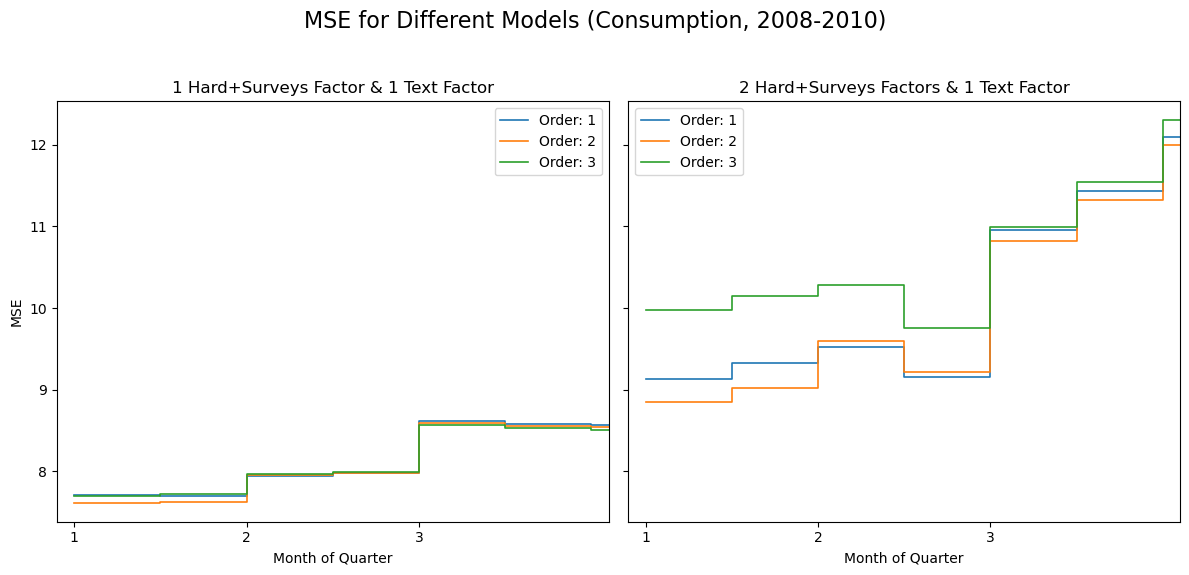

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


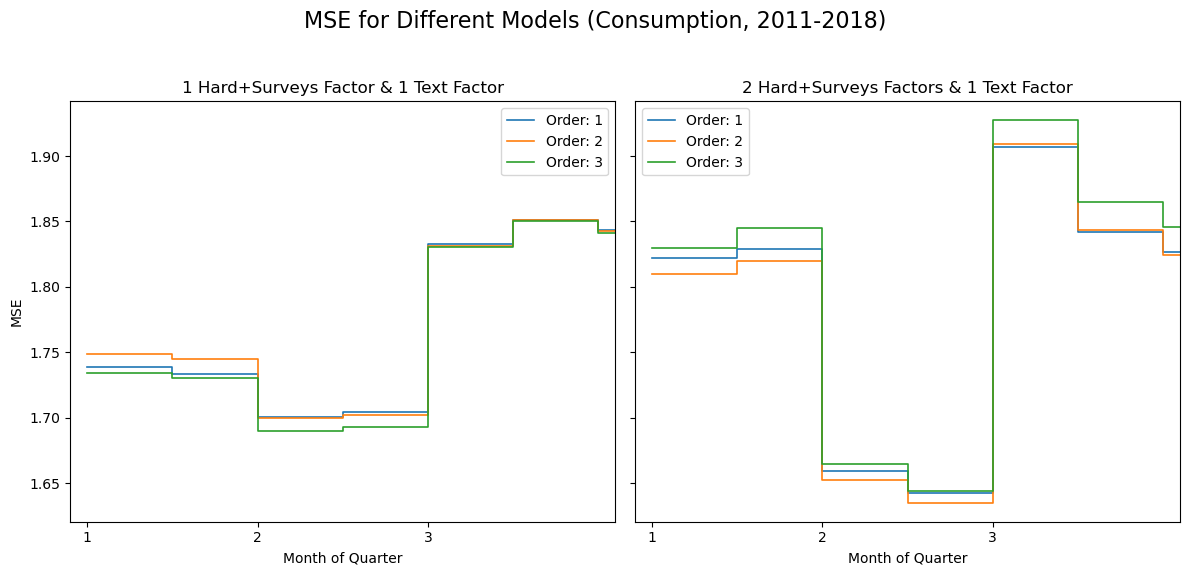

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


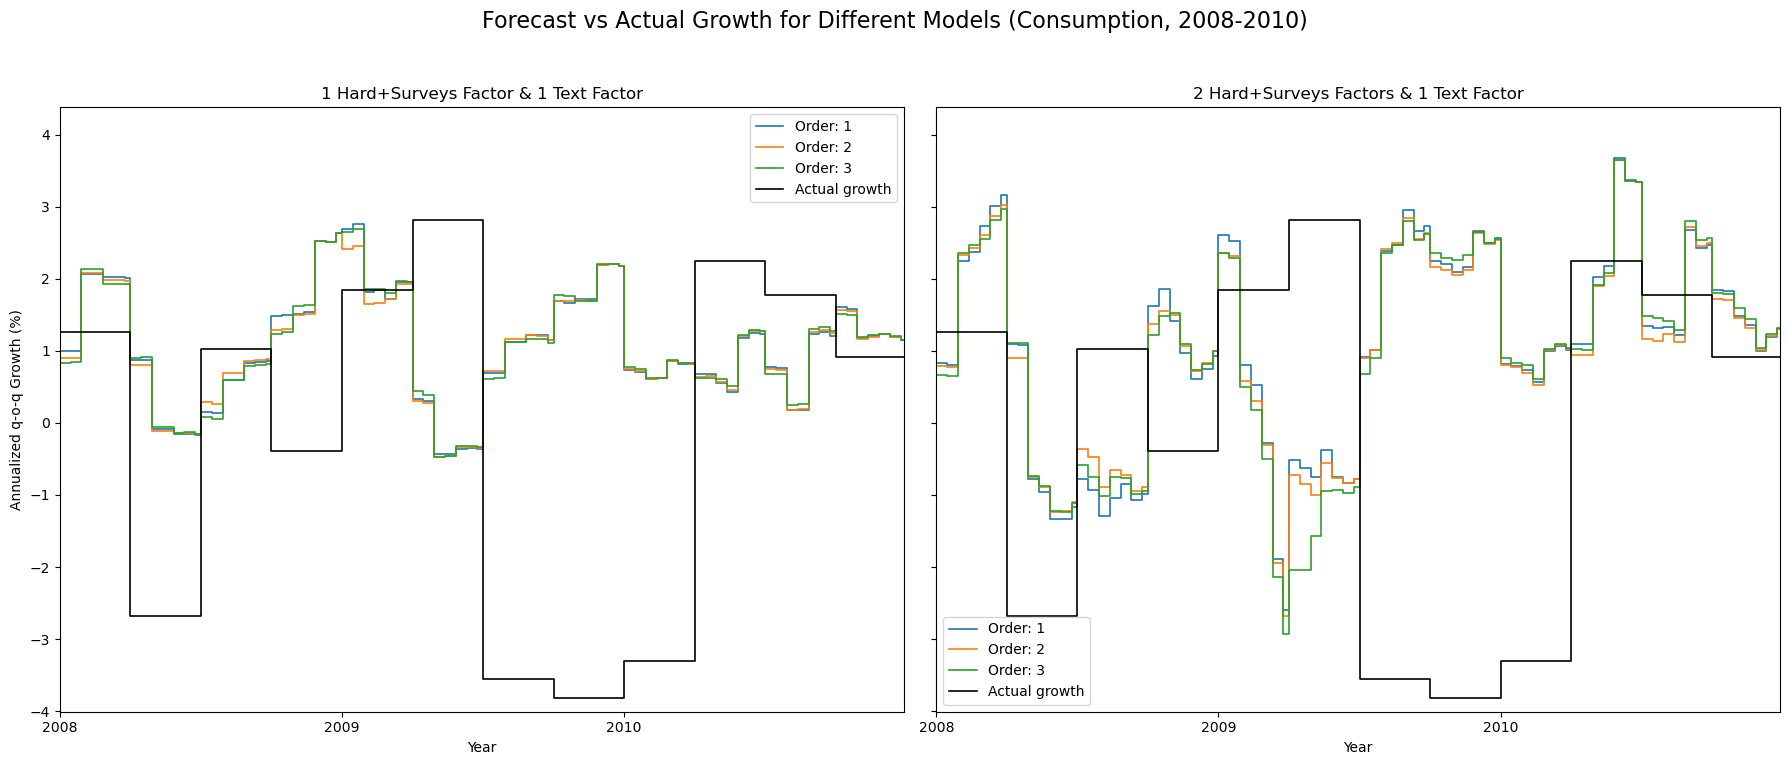

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


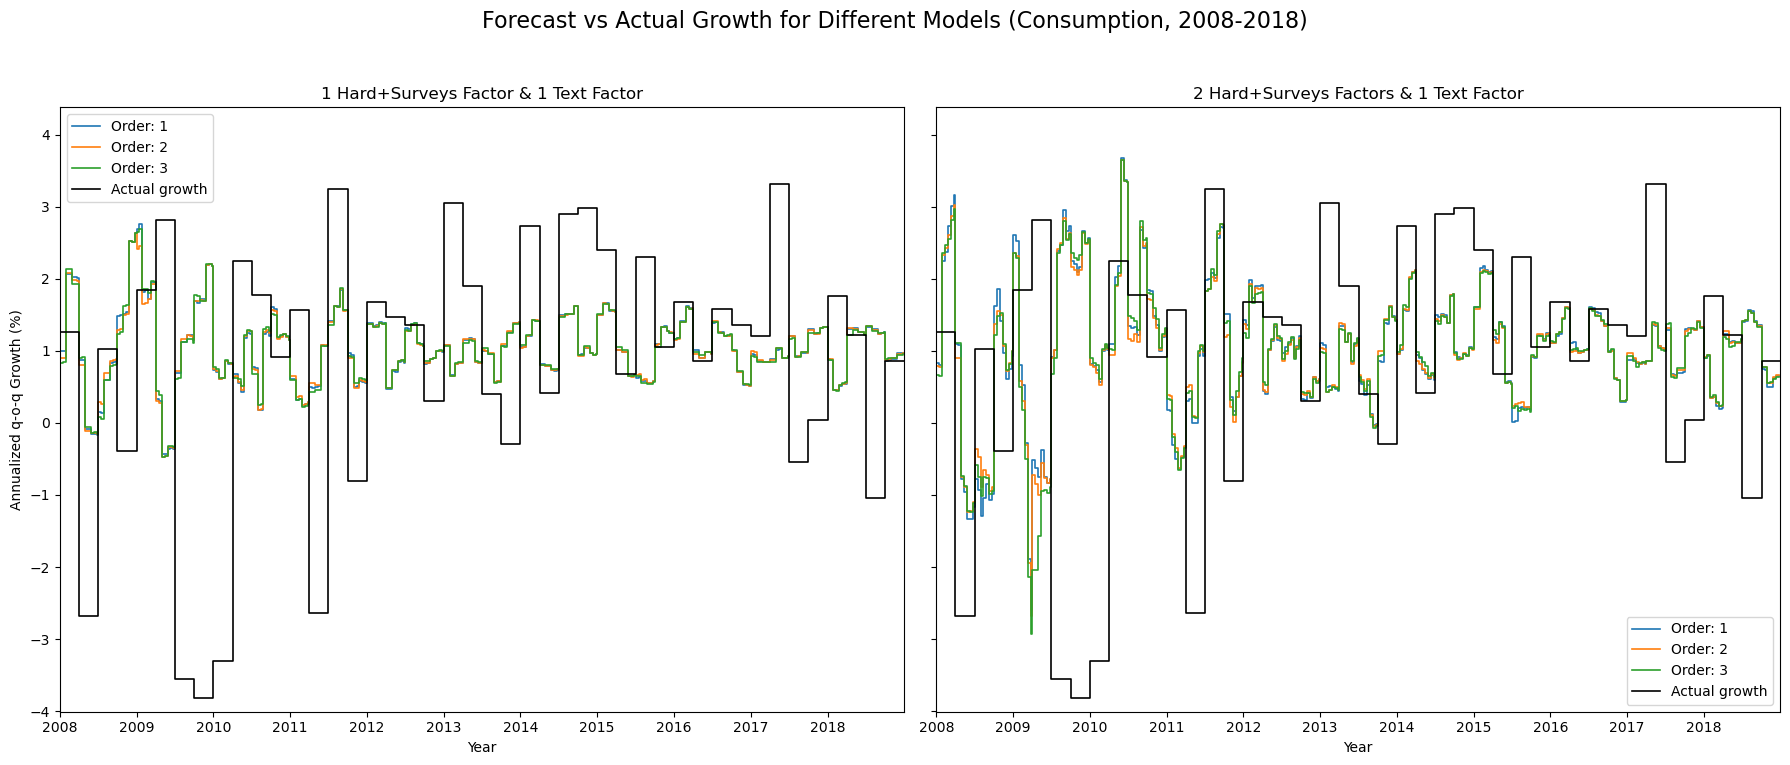

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


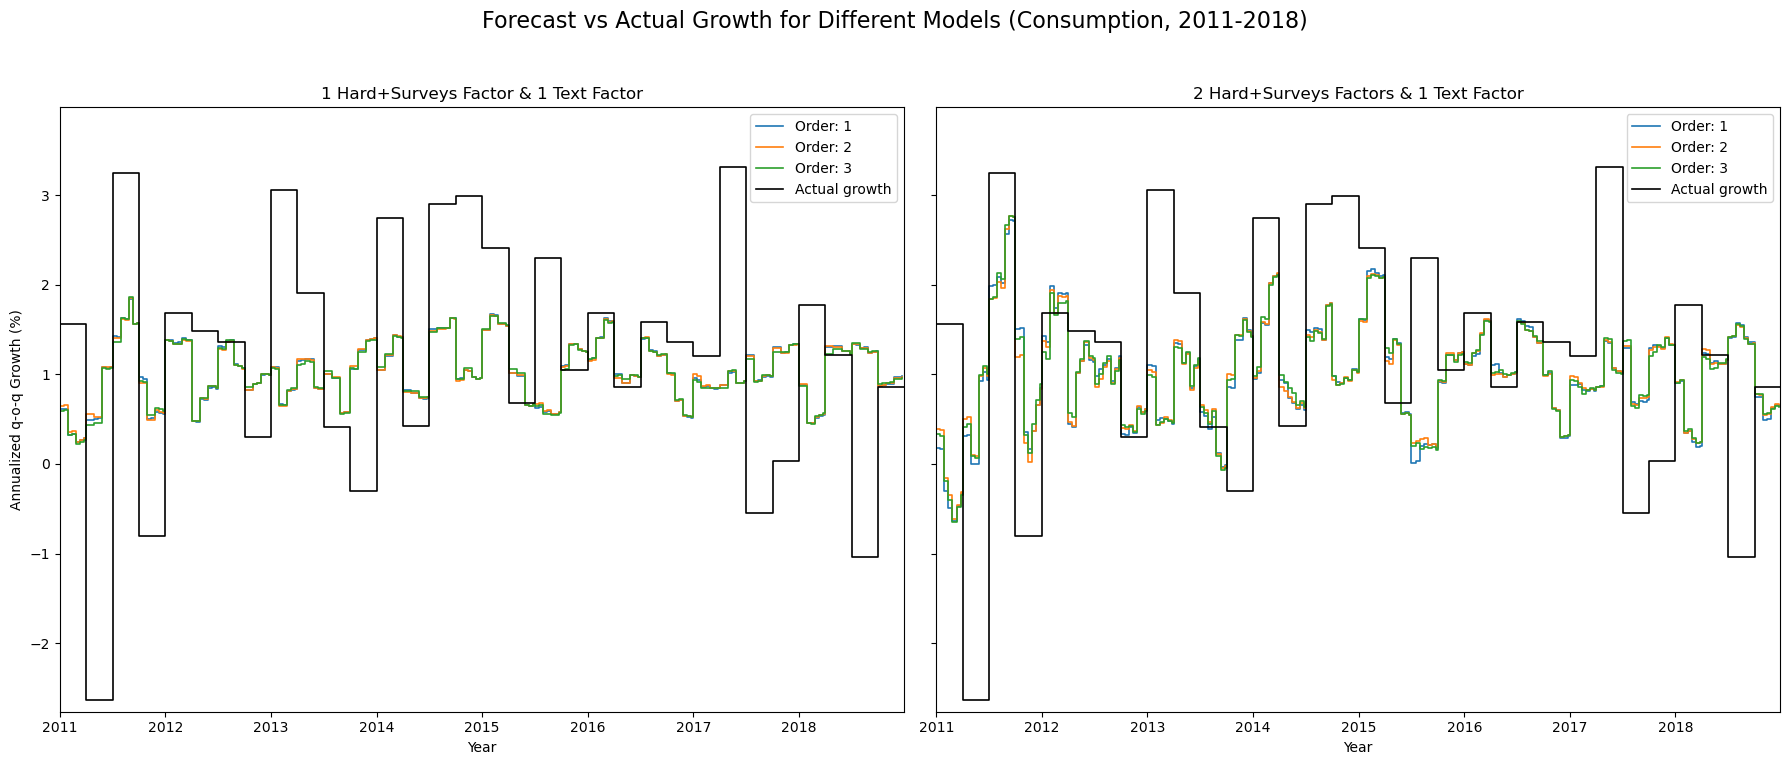

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()